Device: cuda
Loading checkpoint: Saved_Models\20_d60.pth


Evaluating Test Set:   0%|                                                                     | 0/530 [00:00<?, ?it/s]

Classes detected: ['fake', 'real']
New Test Set Size: 4240 samples


Evaluating Test Set: 100%|███████████████████████████████████████████████████████████| 530/530 [01:23<00:00,  6.35it/s]



Classification Report:
              precision    recall  f1-score   support

        fake       0.94      0.91      0.92      2768
        real       0.84      0.89      0.86      1472

    accuracy                           0.90      4240
   macro avg       0.89      0.90      0.89      4240
weighted avg       0.90      0.90      0.90      4240


===== FINAL TEST RESULTS (15% SPLIT) =====
Accuracy:   0.9009
Precision:  0.8350
Recall:     0.8906
F1-score:   0.8619
AUC-ROC:    0.9633



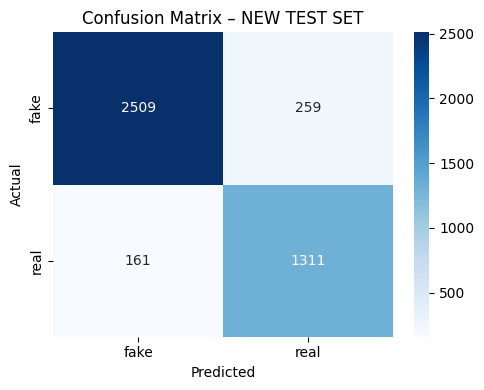

In [7]:
import os
import random
import numpy as np
import torch
import torchvision
import PIL
from torch.utils.data import Subset, DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
dataset_path = r"E:\CVL\finalproject\Model Testing\Datasets\Datasets"

# ---- (1) Select device ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---- (2) Load trained checkpoint ----
best_model_path = os.path.join("Saved_Models", "20_d60.pth")   # change if needed
print("Loading checkpoint:", best_model_path)

model = torch.load(best_model_path, map_location=device)
model.to(device)
model.eval()

# ---- (3) Dataset path ----
valid_path = os.path.join(dataset_path, "valid")

# ---- (4) Deterministic transforms (NO ImgAugTransform, no randomness) ----
stats = ((0.4914, 0.4822, 0.4465),
         (0.2023, 0.1994, 0.2010))

test_tfms = torchvision.transforms.Compose([
    lambda x: PIL.Image.fromarray(x) if not isinstance(x, PIL.Image.Image) else x,
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(*stats, inplace=True)
])

# ---- (5) Load validation dataset ----
full_val_ds = ImageFolder(valid_path, transform=test_tfms)
class_names = full_val_ds.classes
print("Classes detected:", class_names)

# ---- (6) Split into new_val (15%) + new_test (15%) ----
indices = list(range(len(full_val_ds)))
random.shuffle(indices)

half = len(indices) // 2
new_val_indices = indices[:half]
new_test_indices = indices[half:]

new_test_ds = Subset(full_val_ds, new_test_indices)

print(f"New Test Set Size: {len(new_test_ds)} samples")

test_loader = DataLoader(new_test_ds, batch_size=8, shuffle=False)

# ---- (7) Evaluate ----
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating Test Set"):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# ---- (7A) Compute metrics ----
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')

# For AUC: need probability score (softmax)
all_probs = []
with torch.no_grad():
    for images, _ in DataLoader(new_test_ds, batch_size=8, shuffle=False):
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # probability for class "Fake" (index 1)
        all_probs.extend(probs.cpu().numpy())

auc_score = roc_auc_score(all_labels, all_probs)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# ---- (7B) Print summary ----
print("\n===== FINAL TEST RESULTS (15% SPLIT) =====")
print(f"Accuracy:   {accuracy:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1-score:   {f1:.4f}")
print(f"AUC-ROC:    {auc_score:.4f}")
print("==========================================\n")

# ===== CONFUSION MATRIX (NEW TEST SET) =====
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    cmap='Blues',
    fmt='d',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Confusion Matrix – NEW TEST SET")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



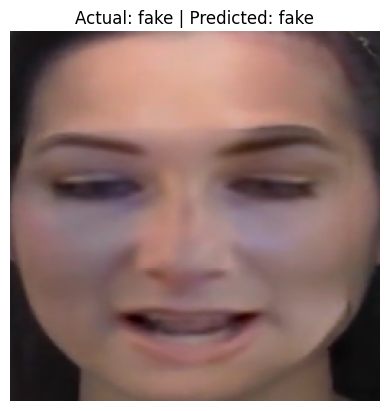

In [8]:
def show_test_prediction(idx=0):
    img_path, true_label = full_val_ds.samples[new_test_indices[idx]]
    img = PIL.Image.open(img_path).convert("RGB")

    input_img = test_tfms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_img)
        _, pred = torch.max(output, 1)

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Actual: {class_names[true_label]} | Predicted: {class_names[pred.item()]}")
    plt.show()

show_test_prediction(10)
